In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Prophet
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('zomato_Stock_Prices.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,7/23/2021,116.000000,138.899994,115.000000,126.000000,126.000000,694895290
1,7/26/2021,126.349998,143.750000,125.300003,140.649994,140.649994,249723854
2,7/27/2021,141.699997,147.800003,127.750000,132.899994,132.899994,240341900
3,7/28/2021,131.000000,135.000000,123.550003,131.199997,131.199997,159793731
4,7/29/2021,134.949997,144.000000,132.199997,141.550003,141.550003,117973089
...,...,...,...,...,...,...,...
626,2/1/2024,141.000000,143.500000,138.550003,140.550003,140.550003,70252449
627,2/2/2024,141.800003,145.000000,141.449997,143.800003,143.800003,78666454
628,2/5/2024,145.000000,145.399994,138.250000,140.250000,140.250000,54189688
629,2/6/2024,140.399994,141.800003,138.050003,139.949997,139.949997,46782951


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       631 non-null    object 
 1   Open       631 non-null    float64
 2   High       631 non-null    float64
 3   Low        631 non-null    float64
 4   Close      631 non-null    float64
 5   Adj Close  631 non-null    float64
 6   Volume     631 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 34.6+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [5]:
df = df.set_index('Date').sort_index()

In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-23,116.000000,138.899994,115.000000,126.000000,126.000000,694895290
2021-07-26,126.349998,143.750000,125.300003,140.649994,140.649994,249723854
2021-07-27,141.699997,147.800003,127.750000,132.899994,132.899994,240341900
2021-07-28,131.000000,135.000000,123.550003,131.199997,131.199997,159793731
2021-07-29,134.949997,144.000000,132.199997,141.550003,141.550003,117973089


In [7]:
# if close and adj close contain same value then dropping adj column 
if (df['Close'] == df['Adj Close']).all():
    df=df.drop('Adj Close',axis =1)

In [8]:
# after dropping adj close
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-07-23,116.000000,138.899994,115.000000,126.000000,694895290
2021-07-26,126.349998,143.750000,125.300003,140.649994,249723854
2021-07-27,141.699997,147.800003,127.750000,132.899994,240341900
2021-07-28,131.000000,135.000000,123.550003,131.199997,159793731
2021-07-29,134.949997,144.000000,132.199997,141.550003,117973089


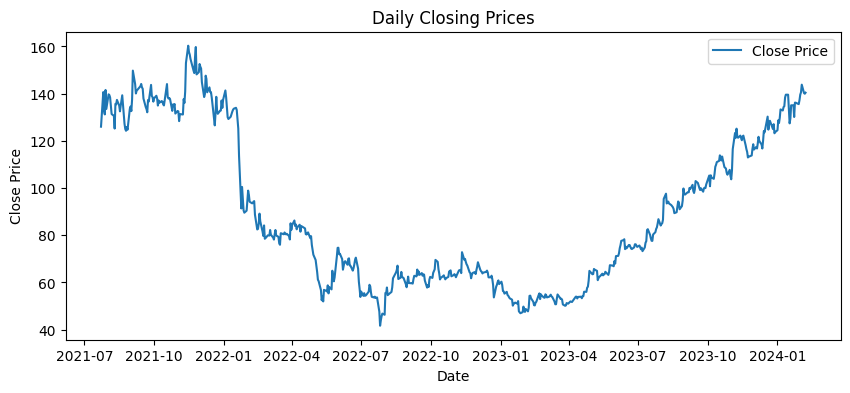

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df['Close'], label="Close Price")
plt.title('Daily Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## Arima Model

In [11]:
### Stationary check for ARIMA Model
result = adfuller(df['Close'])
print('ADF Statistics:',result[0])
print('P-value:',result[1])

if result[1]>0.05:
    print('This series is not stationary. Differencing will be applied')
    df['Close_diff'] = df['Close'].diff().dropna()

else:
    print('The series is stationary. Proceeding without differencing.')

ADF Statistics: -0.956977036549261
P-value: 0.7686308939488031
This series is not stationary. Differencing will be applied


In [12]:
df.head(5)

,Open,High,Low,Close,Volume,Close_diff
Date,,,,,,
2021-07-23,116.000000,138.899994,115.000000,126.000000,694895290,NaN
2021-07-26,126.349998,143.750000,125.300003,140.649994,249723854,14.649994
2021-07-27,141.699997,147.800003,127.750000,132.899994,240341900,-7.750000
2021-07-28,131.000000,135.000000,123.550003,131.199997,159793731,-1.699997
2021-07-29,134.949997,144.000000,132.199997,141.550003,117973089,10.350006


In [13]:
# drop the first row
df = df.drop(df.index[0])

In [14]:
df.head(5)

,Open,High,Low,Close,Volume,Close_diff
Date,,,,,,
2021-07-26,126.349998,143.750000,125.300003,140.649994,249723854,14.649994
2021-07-27,141.699997,147.800003,127.750000,132.899994,240341900,-7.750000
2021-07-28,131.000000,135.000000,123.550003,131.199997,159793731,-1.699997
2021-07-29,134.949997,144.000000,132.199997,141.550003,117973089,10.350006
2021-07-30,142.600006,142.699997,131.000000,133.500000,88312522,-8.050003


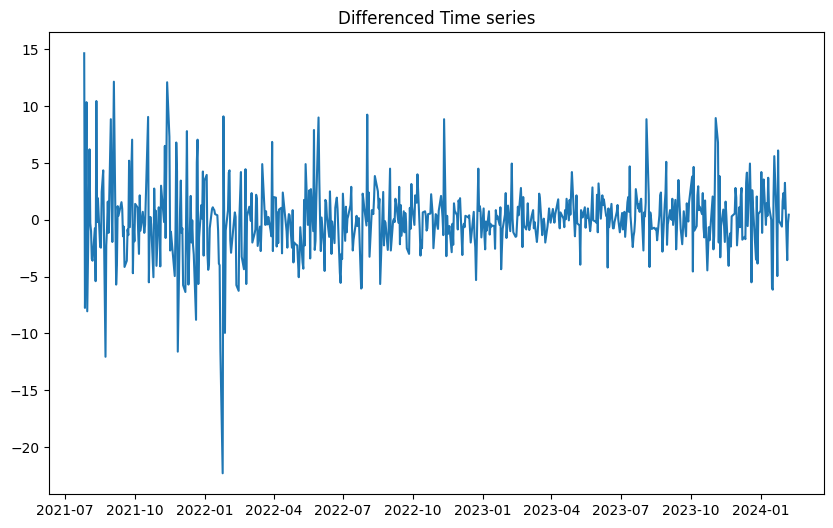

In [15]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Close_diff'],label='Differenced Series')
plt.title("Differenced Time series")
plt.show()

In [16]:
result_diff = adfuller(df['Close_diff'])
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

if result_diff[1] > 0.05:
    print("The differenced series is still not stationary.")
else:
    print("The differenced series is stationary. Ready for ARIMA modeling.")


ADF Statistic (Differenced): -26.207256410933613
p-value (Differenced): 0.0
The differenced series is stationary. Ready for ARIMA modeling.


In [17]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close_diff'], dtype='object')

In [18]:
df.head()

,Open,High,Low,Close,Volume,Close_diff
Date,,,,,,
2021-07-26,126.349998,143.750000,125.300003,140.649994,249723854,14.649994
2021-07-27,141.699997,147.800003,127.750000,132.899994,240341900,-7.750000
2021-07-28,131.000000,135.000000,123.550003,131.199997,159793731,-1.699997
2021-07-29,134.949997,144.000000,132.199997,141.550003,117973089,10.350006
2021-07-30,142.600006,142.699997,131.000000,133.500000,88312522,-8.050003


In [19]:
df1 = df.copy()

In [20]:
df = df.drop('Close_diff',axis=1)

In [21]:
df.shape

(630, 5)

In [22]:
series = df['Close'].astype(float)

In [23]:
series.index = pd.to_datetime(series.index)

In [24]:
series

Date
2021-07-26    140.649994
2021-07-27    132.899994
2021-07-28    131.199997
2021-07-29    141.550003
2021-07-30    133.500000
                 ...    
2024-02-01    140.550003
2024-02-02    143.800003
2024-02-05    140.250000
2024-02-06    139.949997
2024-02-07    140.399994
Name: Close, Length: 630, dtype: float64

In [25]:
# all those values is in day freq. so that it can be show NaN for holiday/ other days
print("inferred_freq (raw):", series.index.inferred_freq) 

inferred_freq (raw): None


In [26]:
df = df.asfreq('B')

In [27]:
# 2. Prepare as BUSINESS DAYS and fill holidays
series = series.asfreq('B')   # uniform business-day index
series = series.ffill()       # forward-fill for holiday gaps 

In [28]:
series.isnull().sum()

0

In [29]:
 # Rolling window evaluation
def rolling_window_eval(series, model_func, window_size=200, horizon=1):
    preds, trues = [], []
    n = len(series)

    for i in range(window_size, n - horizon + 1):
        train = series[i - window_size:i]
        test = series[i:i+horizon]
        forecast = model_func(train, horizon)
        preds.extend(forecast)
        trues.extend(test.values)

    return np.array(trues), np.array(preds) 

In [30]:
import pmdarima as pm

In [31]:
arima_model = pm.auto_arima(series,seasonal=False,trace=True) 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3784.940, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3633.742, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3782.945, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3539.090, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3481.519, Time=0.15 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=3458.749, Time=0.23 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=3440.425, Time=0.29 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=3438.427, Time=0.12 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=3456.751, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.27 s

In [32]:
print(arima_model.summary()) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  663
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -1713.214
Date:                Sat, 04 Oct 2025   AIC                           3438.427
Time:                        19:37:06   BIC                           3465.390
Sample:                    07-26-2021   HQIC                          3448.877
                         - 02-07-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8254      0.023    -35.514      0.000      -0.871      -0.780
ar.L2         -0.7408      0.031    -23.780      0.000      -0.802      -0.680
ar.L3         -0.5544      0.035    -15.760      0.0

In [33]:
best_order = arima_model.order
print('Auto ARIMA suggested order:', best_order)

Auto ARIMA suggested order: (5, 2, 0)


In [34]:
def arima_forecast(train, horizon=1, order=(5,2,0)):
    try:
        model = ARIMA(train, order=order)
        fit = model.fit()
        return fit.forecast(steps=horizon)
    except:
        # If ARIMA fails, return last observed value (naive forecast)
        return [train.iloc[-1]] * horizon

In [35]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1, y_true))) * 100

#### Rolling Evaluation with Metrics- Arima Model

In [37]:
arima_trues, arima_preds = rolling_window_eval(series, arima_forecast,
                                               window_size=200, horizon=1)
arima_rmse = sqrt(mean_squared_error(arima_trues, arima_preds))
arima_mape = mean_absolute_percentage_error(arima_trues, arima_preds)
print(f"ARIMA -> RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")

ARIMA -> RMSE: 2.5433, MAPE: 2.53%


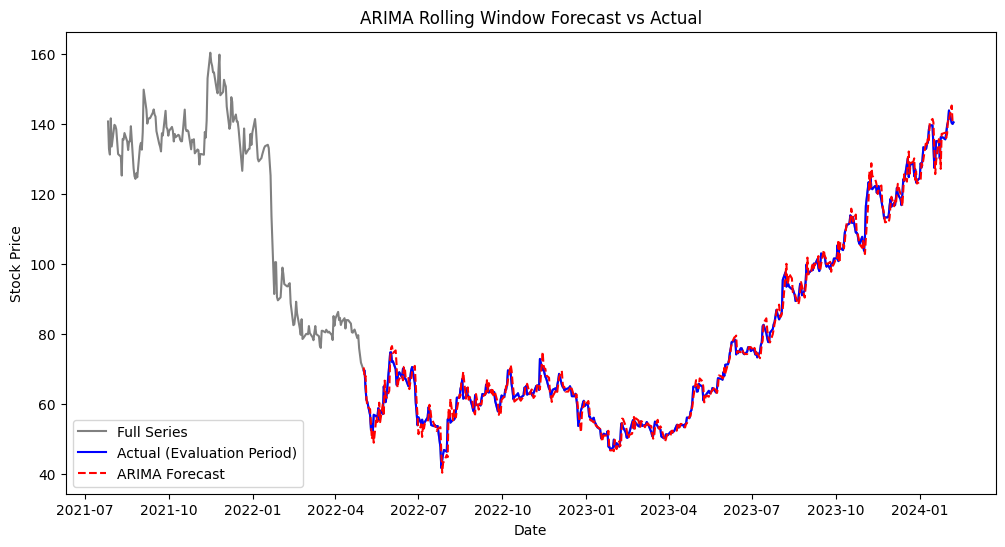

In [39]:
import matplotlib.pyplot as plt

# Align the evaluation period with your true/pred arrays
start_idx = len(series) - len(arima_trues)
time_index = series.index[start_idx:]   # corresponding dates

plt.figure(figsize=(12,6))

# full series in gray
plt.plot(series.index, series.values, color="gray", label="Full Series")

# actual vs predicted during evaluation
plt.plot(time_index, arima_trues, color="blue", label="Actual (Evaluation Period)")
plt.plot(time_index, arima_preds, color="red", linestyle="--", label="ARIMA Forecast")

plt.title("ARIMA Rolling Window Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#### Forecasting Next 365 Days with Arima Model

In [41]:
series = series.asfreq('B')

In [42]:
arima = ARIMA(series, order=(5,2,0))
arima_fitted = arima.fit()

In [43]:
forecast_steps = 365  # Number of steps to forecast
forecast = arima_fitted.forecast(steps=forecast_steps)
print("ARIMA Forecast:\n",forecast)

ARIMA Forecast:
 2024-02-08    141.084677
2024-02-09    141.080867
2024-02-12    141.184869
2024-02-13    140.751445
2024-02-14    140.851741
                 ...    
2025-06-26    153.295949
2025-06-27    153.330516
2025-06-30    153.365083
2025-07-01    153.399651
2025-07-02    153.434218
Freq: B, Name: predicted_mean, Length: 365, dtype: float64


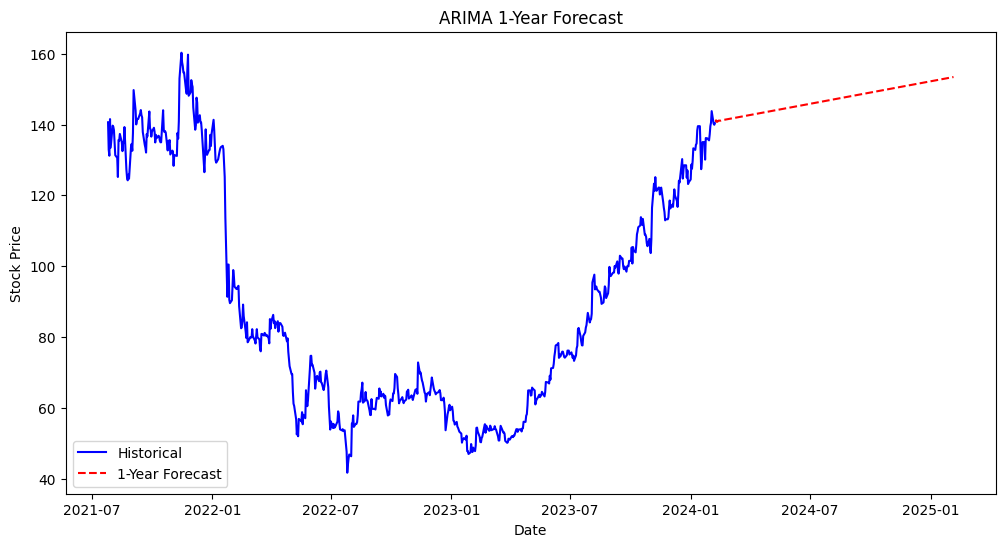

In [44]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(series.index, series.values, color="blue", label="Historical")
plt.plot(pd.date_range(series.index[-1], periods=365, freq='D'),
         forecast, color="red", linestyle="--", label="1-Year Forecast")
plt.title("ARIMA 1-Year Forecast")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Prophet Model

In [46]:
series_prop = df['Close'].astype(float)
series_prop.head()

Date
2021-07-26    140.649994
2021-07-27    132.899994
2021-07-28    131.199997
2021-07-29    141.550003
2021-07-30    133.500000
Freq: B, Name: Close, dtype: float64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 663 entries, 2021-07-26 to 2024-02-07
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    630 non-null    float64
 1   High    630 non-null    float64
 2   Low     630 non-null    float64
 3   Close   630 non-null    float64
 4   Volume  630 non-null    float64
dtypes: float64(5)
memory usage: 31.1 KB


In [48]:
df_prop = df.reset_index()

In [49]:
df_prop= df_prop.dropna()

In [50]:
df_prop = df_prop.drop(columns=['Open','High','Low','Volume'])

In [51]:
df_prop.columns=('ds','y')
df_prop.head()

,ds,y
0,2021-07-26,140.649994
1,2021-07-27,132.899994
2,2021-07-28,131.199997
3,2021-07-29,141.550003
4,2021-07-30,133.500000


In [52]:
df_prop.shape

(630, 2)

In [54]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(df_prop)

19:38:03 - cmdstanpy - INFO - Chain [1] start processing
19:38:03 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
future = m.make_future_dataframe(periods=365,freq='B')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-26,139.445133,122.116430,143.102113,139.445133,139.445133,-6.766045,-6.766045,-6.766045,-1.06629,...,-0.100010,-0.100010,-0.100010,-5.599745,-5.599745,-5.599745,0.0,0.0,0.0,132.679088
1,2021-07-27,139.377636,122.043888,143.733858,139.377636,139.377636,-6.619853,-6.619853,-6.619853,-1.06629,...,-0.288424,-0.288424,-0.288424,-5.265139,-5.265139,-5.265139,0.0,0.0,0.0,132.757783
2,2021-07-28,139.310138,122.413168,143.240413,139.310138,139.310138,-6.043193,-6.043193,-6.043193,-1.06629,...,-0.043590,-0.043590,-0.043590,-4.933313,-4.933313,-4.933313,0.0,0.0,0.0,133.266945
3,2021-07-29,139.242641,123.230941,144.038625,139.242641,139.242641,-5.592837,-5.592837,-5.592837,-1.06629,...,0.080775,0.080775,0.080775,-4.607322,-4.607322,-4.607322,0.0,0.0,0.0,133.649804
4,2021-07-30,139.175143,122.560492,144.350451,139.175143,139.175143,-5.271547,-5.271547,-5.271547,-1.06629,...,0.084678,0.084678,0.084678,-4.289936,-4.289936,-4.289936,0.0,0.0,0.0,133.903596


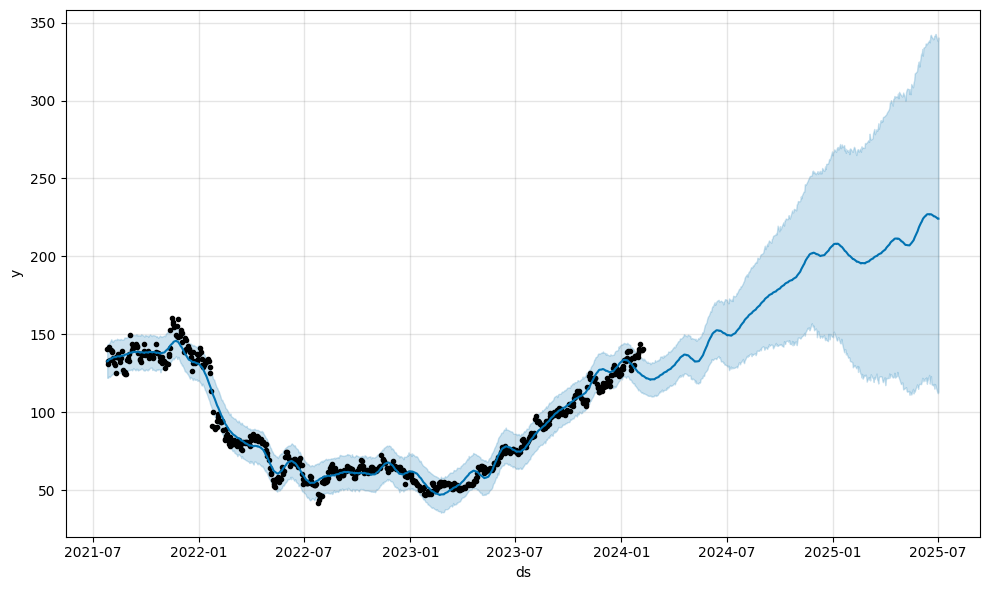

In [56]:
plot1 = m.plot(forecast)

### Rolling Evaluation with Metrics- Prophet Model

In [58]:
df_prop = df_prop.set_index('ds').asfreq('B').ffill().reset_index()

In [59]:
def prophet_forecast(train_df, horizon=1):
    m = Prophet(daily_seasonality=True)
    m.fit(train_df)
    future = m.make_future_dataframe(periods=horizon, freq='B')
    forecast = m.predict(future)
    return forecast['yhat'].tail(horizon).values

In [60]:
def rolling_window_eval_prophet(df_prop, window_size=200, horizon=1):
    preds, trues = [], []
    n = len(df_prop)
    
    for i in range(window_size, n - horizon + 1):
        train_df = df_prop.iloc[i - window_size:i][['ds','y']]
        test_df = df_prop.iloc[i:i+horizon]
        
        forecast = prophet_forecast(train_df, horizon)
        preds.extend(forecast)
        trues.extend(test_df['y'].values)
    
    return np.array(trues), np.array(preds)

In [61]:
prophet_trues, prophet_preds = rolling_window_eval_prophet(df_prop, window_size=200, horizon=1)

19:38:03 - cmdstanpy - INFO - Chain [1] start processing
19:38:03 - cmdstanpy - INFO - Chain [1] done processing
19:38:04 - cmdstanpy - INFO - Chain [1] start processing
19:38:04 - cmdstanpy - INFO - Chain [1] done processing
19:38:04 - cmdstanpy - INFO - Chain [1] start processing
19:38:04 - cmdstanpy - INFO - Chain [1] done processing
19:38:04 - cmdstanpy - INFO - Chain [1] start processing
19:38:04 - cmdstanpy - INFO - Chain [1] done processing
19:38:04 - cmdstanpy - INFO - Chain [1] start processing
19:38:04 - cmdstanpy - INFO - Chain [1] done processing
19:38:04 - cmdstanpy - INFO - Chain [1] start processing
19:38:04 - cmdstanpy - INFO - Chain [1] done processing
19:38:04 - cmdstanpy - INFO - Chain [1] start processing
19:38:04 - cmdstanpy - INFO - Chain [1] done processing
19:38:05 - cmdstanpy - INFO - Chain [1] start processing
19:38:05 - cmdstanpy - INFO - Chain [1] done processing
19:38:05 - cmdstanpy - INFO - Chain [1] start processing
19:38:05 - cmdstanpy - INFO - Chain [1]

In [62]:
prop_rmse = sqrt(mean_squared_error(prophet_trues, prophet_preds))
prop_mape = mean_absolute_percentage_error(prophet_trues, prophet_preds)

In [66]:
print(f"Prophet -> RMSE: {prop_rmse:.4f}%, MAPE: {prop_mape:.4f}")

Prophet -> RMSE: 5.3216%, MAPE: 6.1375


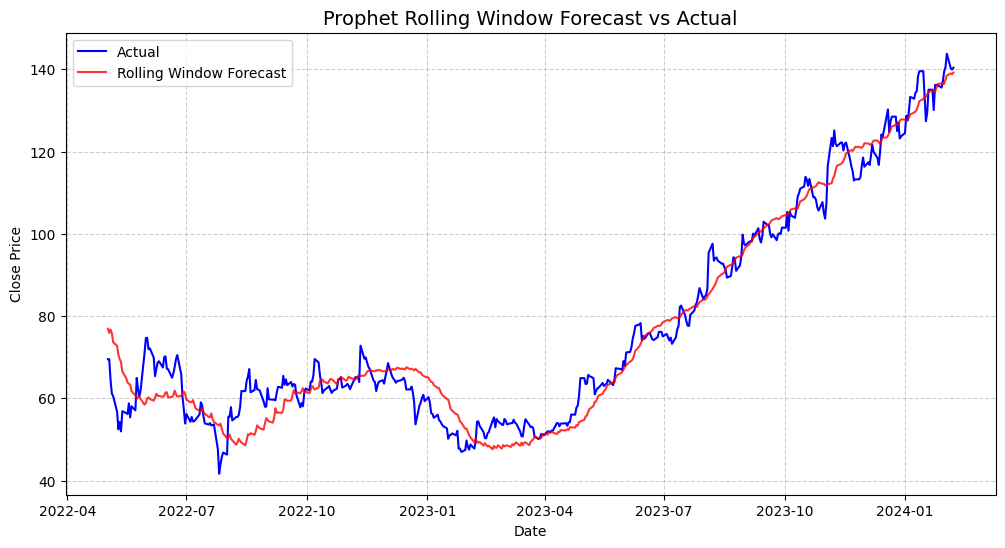

In [68]:
# Plot Rolling Window Forecast vs Actual
plt.figure(figsize=(12,6))
plt.plot(df_prop['ds'][-len(prophet_trues):], prophet_trues, 
         label='Actual', color='blue')
plt.plot(df_prop['ds'][-len(prophet_preds):], prophet_preds, 
         label='Rolling Window Forecast', color='red', alpha=0.8)

plt.title("Prophet Rolling Window Forecast vs Actual", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Prediction for Next 365 days 

In [71]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(df_prop)

19:39:57 - cmdstanpy - INFO - Chain [1] start processing
19:39:57 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
future = m.make_future_dataframe(periods=365,freq='B')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-26,139.263032,121.717491,142.526387,139.263032,139.263032,-7.100925,-7.100925,-7.100925,-1.609162,...,-0.181913,-0.181913,-0.181913,-5.309850,-5.309850,-5.309850,0.0,0.0,0.0,132.162107
1,2021-07-27,139.211080,121.883830,143.581114,139.211080,139.211080,-6.863310,-6.863310,-6.863310,-1.609162,...,-0.282063,-0.282063,-0.282063,-4.972086,-4.972086,-4.972086,0.0,0.0,0.0,132.347770
2,2021-07-28,139.159129,122.840657,143.669568,139.159129,139.159129,-6.324516,-6.324516,-6.324516,-1.609162,...,-0.078858,-0.078858,-0.078858,-4.636496,-4.636496,-4.636496,0.0,0.0,0.0,132.834613
3,2021-07-29,139.107177,121.988590,143.708039,139.107177,139.107177,-5.869811,-5.869811,-5.869811,-1.609162,...,0.045575,0.045575,0.045575,-4.306224,-4.306224,-4.306224,0.0,0.0,0.0,133.237366
4,2021-07-30,139.055225,123.109476,144.242562,139.055225,139.055225,-5.498353,-5.498353,-5.498353,-1.609162,...,0.094969,0.094969,0.094969,-3.984161,-3.984161,-3.984161,0.0,0.0,0.0,133.556872


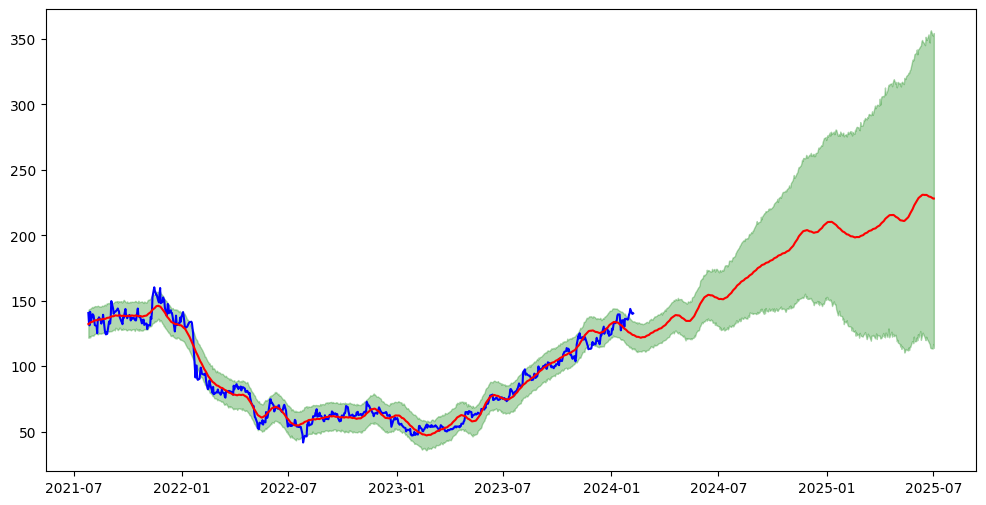

In [75]:
plt.figure(figsize=(12,6))
plt.plot(df_prop['ds'], df_prop['y'], label="Actual", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='green', alpha=0.3, label="Uncertainty Interval")

In [77]:
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet"],
    "RMSE": [arima_rmse, prop_rmse],
    "MAPE": [arima_mape, prop_mape]
})
print(results)

     Model      RMSE      MAPE
0    ARIMA  2.543295  2.527910
1  Prophet  5.321644  6.137466


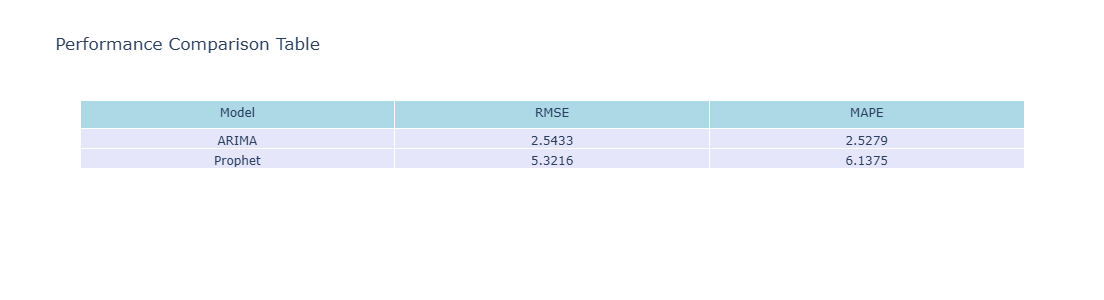

In [98]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(results.columns),
                fill_color='lightblue',
                align='center'),
    cells=dict(values=[results[col].round(4) for col in results.columns],
               fill_color='lavender',
               align='center'))
])

fig.update_layout(title="Performance Comparison Table")
fig.update_layout(
    title="Performance Comparison Table",
    width=700,   # wider
    height=300   # taller
)
fig.show()


In [102]:
df_prop.head()

,ds,y
0,2021-07-26,140.649994
1,2021-07-27,132.899994
2,2021-07-28,131.199997
3,2021-07-29,141.550003
4,2021-07-30,133.500000


In [110]:
import pickle

with open("model_arima.pkl", "wb") as f:
    pickle.dump(arima_fitted, f)

In [112]:
# Save Prophet
with open("model_prophet.pkl", "wb") as f:
    pickle.dump(prophet_model, f)
